In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from osgeo import gdal
from affine import Affine
import pandas as pd
import geopandas as gpd
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/Users/allen/Documents/Python/PlotGallary/')
from matplotlibconfig import basic

basic()
# plt.style.use('seaborn-white')

In [2]:
h5= h5py.File('test_sample.HDF5','r')
result= h5py.File('datasets/post_result.h5','r')
grided_map= h5['Grid']
# load geo information
lons= np.array(h5['Grid/lon'])
lats= np.array(h5['Grid/lat'])
data= np.array(h5['Grid/precipitationCal']).transpose()
xmin, ymin, xmax, ymax = [lons.min(), lats.min(), lons.max(), lats.max()]
xres, yres, _= data.shape
ncol, nrow= int((xmax-xmin)//xres), int((ymax-ymin)//yres)
lon_diff= lons[1]-lons[0]
lat_diff= lats[1]-lats[0]

#load each item
early_sum= result['early sum'][:]
final_sum= result['final sum'][:]
final_daily= np.divide(final_sum, 6969, out= np.full(final_sum.shape, np.nan))
final_sum[final_sum<0]=np.nan
early_sum[early_sum<0]=np.nan
early_sum[early_sum<=1]=np.nan
bias= np.divide(early_sum-final_sum, final_sum, where= final_sum!=0, out= np.full(early_sum.shape,np.nan) )
# bias[bias<0]= np.nan
mae= result['mae'][:]*6969*48
rmse= result['rmse'][:]**2*6969*48
rainySamples= result['prob'][:][:3,:,:].sum(axis=0)
mae= np.divide(mae, rainySamples, out= np.full(mae.shape, np.nan))
rmse= np.divide(rmse, rainySamples, out= np.full(rmse.shape, np.nan))
rmse= rmse**.5

_prob= result['prob'][:]
a,b,c,d= _prob[0,:,:],_prob[1,:,:],_prob[2,:,:],_prob[3,:,:]
rainy_E= a+c
rainy_F= a+b
bias_rainy= np.divide(rainy_E-rainy_F, rainy_F, where= rainy_F!=0, out= np.full(early_sum.shape,np.nan))
FAR= b/(a+b)

# seperate sea and land
glob_cls= gdal.Open('geotiffs/RenderData.tiff')
glob_cls= glob_cls.ReadAsArray()
glob_cls= np.flip(glob_cls, axis=0)

sea= np.where(glob_cls==0)
land= np.where(glob_cls!=0)

final_daily_land= final_daily.copy()
final_daily_land[sea]= np.nan
final_daily_land= np.flip(final_daily_land,axis=0)

dem= gdal.Open('geotiffs/global_elevation.tif')
rmse= gdal.Open('geotiffs/rmse_for_dem.tif')
cls_land= gdal.Open('geotiffs/cls_for_dem.tif')
arr_dem= dem.ReadAsArray()
arr_rmse= rmse.ReadAsArray()
arr_rmse= np.flip(arr_rmse, axis=0)

sea= np.where(cls_land.ReadAsArray()==0)
arr_dem[sea]= np.nan
arr_rmse[sea]= np.nan
arr_rmse_norm= np.divide(arr_rmse, final_daily_land[70:1470, :]**.5, where= final_daily_land[70:1470, :]!=0)
bias_land= bias.copy()[70:1470, :]
bias_land[sea]= np.nan

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in sqrt


### Relationships of DEM and RMSE

In [3]:
arr_dem= arr_dem.reshape(-1,1)
# arr_rmse= arr_rmse.reshape(-1,1)
# arr_rmse_norm= arr_rmse_norm.reshape(-1,1)
# bias_land= bias.copy()
# bias_land[sea]= np.nan
arr_bias= np.flip(bias[340: -60],axis=0).reshape(-1,1)
arr_bias_rainy= np.flip(bias_rainy[340: -60],axis=0).reshape(-1,1)
# arr_rmse= np.flip(arr_rmse, axis=0).reshape(-1,1)
mask= (~np.isnan(arr_dem)) & (~np.isnan(arr_bias)) 
mask1= (~np.isnan(arr_dem)) & (~np.isnan(arr_bias_rainy)) 
# mask= (~np.isnan(arr_dem)) & (~np.isnan(arr_rmse_norm)) 
arr_dem= arr_dem[mask]
# arr_rmse_norm= arr_rmse_norm[mask]
arr_bias= arr_bias[mask]
arr_bias_rainy= arr_bias_rainy[mask]
# arr_rmse= arr_rmse[mask]
# arr_dem= arr_dem[(~np.isnan(arr_dem)) & (~np.isnan(arr_rmse))]
# arr_rmse= arr_rmse[(~np.isnan(arr_rmse)) & (~np.isnan(arr_dem))]

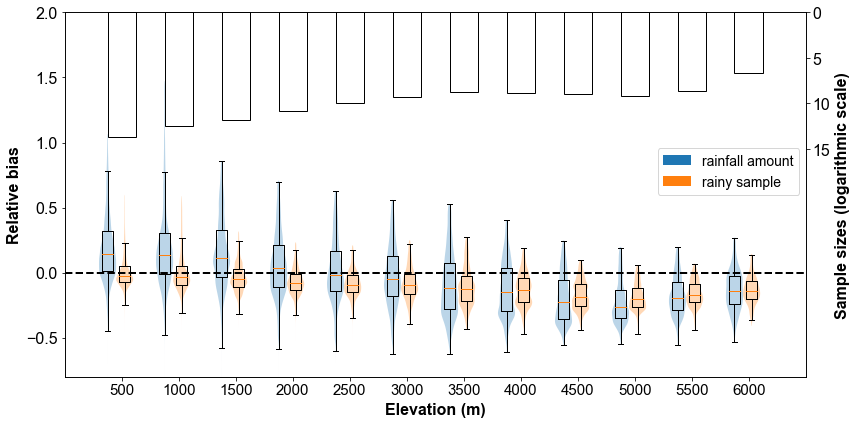

In [4]:
bin_width= np.arange(0,6500,500)
grouped_ind= [np.where((arr_dem>=bin_width[i]) & (arr_dem<bin_width[i+1])) for i in range(len(bin_width)-1)]
grouped_bias= [arr_bias[group][(arr_bias[group]<=np.nanquantile(arr_bias[group], .95))] for group in grouped_ind]
grouped_bias_rainy= [arr_bias_rainy[group][(arr_bias_rainy[group]<=np.nanquantile(arr_bias_rainy[group], .95))] for group in grouped_ind]
fig, ax= plt.subplots(1,1,figsize=(12,6))
# ax.boxplot(grouped_rmse, showfliers=False,showmeans=True, notch=True);
ax.violinplot(grouped_bias, showmedians=False, showextrema=False, widths= 0.3, positions=np.arange(len(bin_width)-1)+.75)
ax.boxplot(grouped_bias, showfliers=False, widths=0.2, positions=np.arange(len(bin_width)-1)+.75)
ax.hist([], color= 'C0', label='rainfall amount')

ax.violinplot(grouped_bias_rainy, showmedians=False, showextrema=False,widths= 0.3, positions=np.arange(len(bin_width)-1)+1.05)
ax.boxplot(grouped_bias_rainy, showfliers=False, widths=0.2, positions=np.arange(len(bin_width)-1)+1.05)
ax.hist([], color='C1', label='rainy sample')
plt.legend(loc= (0.8,0.5))
ax.set_ylim([-0.8,2])
ax.set_xlim([0,13])
ax.hlines(0., 0., 13, linestyle='dashed', color='black')
ax.set_ylabel('Relative bias', fontsize= 16)
ax2= ax.twinx()
ax2.bar(range(1,13), [np.log(len(group)) for group in grouped_bias], alpha=1,color='None', edgecolor='black', width=0.5)
# ax2.violinplot(range(1,13), [np.log(len(group)) for group in grouped_rmse], edgecolor='black', width=0.5)
ax2.set_ylim([0,40])
ax2.set_yticks(np.arange(0,20,5))
ax2.set_yticklabels([str(i) for i in range(0,20,5)])
ax2.set_ylabel('Sample sizes (logarithmic scale)', fontsize=16)
# ax2.set_yscale('log')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax.set_xlabel('Elevation (m)', fontsize=16)
ax.set_xticks(range(1, 13))
# ax.set_xticklabels(['%d-%d'%(bin_width[i], bin_width[i+1]) for i in range(len(bin_width)-1)], fontsize=10)
ax.set_xticklabels(['%d'%(bin_width[i+1]) for i in range(len(bin_width)-1)], fontsize=15)
# plt.legend([ht1[0], ht2[0]], [ht1[1], ht2[1]])
plt.tight_layout();
# fig.savefig('orographic_effects_bias_revised1.png', dpi=300);

In [13]:
np.max([abs(np.nanmedian(each)) for each in grouped_bias])

0.26711133212832905

In [5]:
[np.nanmean(each) for each in grouped_bias_rainy[:4]]

[0.00964608667569712,
 0.004136013029311491,
 -0.036097143244134856,
 -0.06947432694857257]

In [6]:
np.mean([np.nanmedian(each) for each in grouped_bias][:4])

0.104947506935474

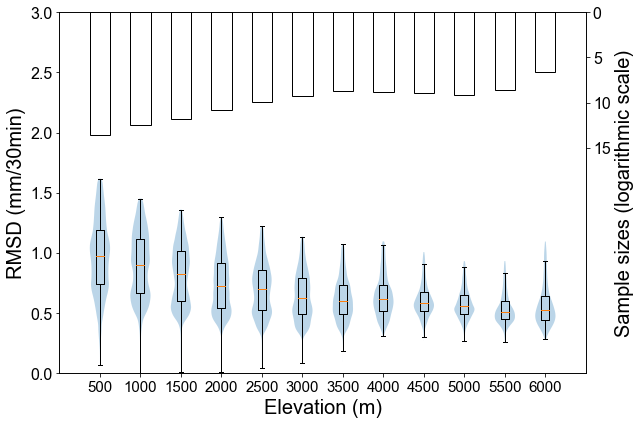

In [40]:
bin_width= np.arange(0,6500,500)
grouped_ind= [np.where((arr_dem>=bin_width[i]) & (arr_dem<bin_width[i+1])) for i in range(len(bin_width)-1)]
grouped_rmse= [arr_rmse[group][(arr_rmse[group]<=np.nanquantile(arr_rmse[group], .95))] for group in grouped_ind]
fig, ax= plt.subplots(1,1,figsize=(9,6))
# ax.boxplot(grouped_rmse, showfliers=False,showmeans=True, notch=True);
ax.violinplot(grouped_rmse, showmedians=False, showextrema=False)
ax.boxplot(grouped_rmse, showfliers=False, widths=0.2)
ax.set_ylim([0,3])
ax.set_xlim([0,13])
# ax.hlines(0., 0., 13, linestyle='dashed', color='black')
ax.set_ylabel('RMSD (mm/30min)', fontsize= 20)
ax2= ax.twinx()
ax2.bar(range(1,13), [np.log(len(group)) for group in grouped_rmse], alpha=1,color='None', edgecolor='black', width=0.5)
# ax2.violinplot(range(1,13), [np.log(len(group)) for group in grouped_rmse], edgecolor='black', width=0.5)
ax2.set_ylim([0,40])
ax2.set_yticks(np.arange(0,20,5))
ax2.set_yticklabels([str(i) for i in range(0,20,5)])
ax2.set_ylabel('Sample sizes (logarithmic scale)', fontsize=20)
# ax2.set_yscale('log')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax.set_xlabel('Elevation (m)', fontsize=20)
ax.set_xticks(range(1, 13))
# ax.set_xticklabels(['%d-%d'%(bin_width[i], bin_width[i+1]) for i in range(len(bin_width)-1)], fontsize=10)
ax.set_xticklabels(['%d'%(bin_width[i+1]) for i in range(len(bin_width)-1)], fontsize=15)
plt.tight_layout()
# fig.savefig('orographic_effects_rmse_revised.png', dpi=300)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


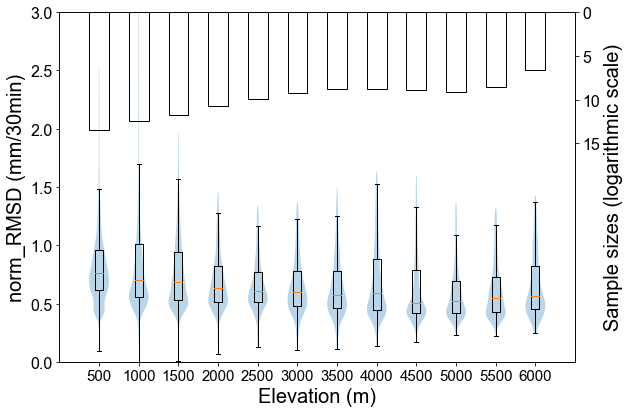

In [72]:
bin_width= np.arange(0,6500,500)
grouped_ind= [np.where((arr_dem>=bin_width[i]) & (arr_dem<bin_width[i+1])) for i in range(len(bin_width)-1)]
grouped_rmse= [arr_rmse_norm[group][(arr_rmse_norm[group]<=np.nanquantile(arr_rmse_norm[group], .95))] for group in grouped_ind]
fig, ax= plt.subplots(1,1,figsize=(9,6))
# ax.boxplot(grouped_rmse, showfliers=False,showmeans=True, notch=True);
ax.violinplot(grouped_rmse, showmedians=False, showextrema=False)
ax.boxplot(grouped_rmse, showfliers=False, widths=0.2)
ax.set_ylim([0,3])
ax.set_xlim([0,13])
# ax.hlines(0., 0., 13, linestyle='dashed', color='black')
ax.set_ylabel('norm_RMSD (mm/30min)', fontsize= 20)
ax2= ax.twinx()
ax2.bar(range(1,13), [np.log(len(group)) for group in grouped_rmse], alpha=1,color='None', edgecolor='black', width=0.5)
# ax2.violinplot(range(1,13), [np.log(len(group)) for group in grouped_rmse], edgecolor='black', width=0.5)
ax2.set_ylim([0,40])
ax2.set_yticks(np.arange(0,20,5))
ax2.set_yticklabels([str(i) for i in range(0,20,5)])
ax2.set_ylabel('Sample sizes (logarithmic scale)', fontsize=20)
# ax2.set_yscale('log')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax.set_xlabel('Elevation (m)', fontsize=20)
ax.set_xticks(range(1, 13))
# ax.set_xticklabels(['%d-%d'%(bin_width[i], bin_width[i+1]) for i in range(len(bin_width)-1)], fontsize=10)
ax.set_xticklabels(['%d'%(bin_width[i+1]) for i in range(len(bin_width)-1)], fontsize=15)
plt.tight_layout()
# fig.savefig('orographic_effects_rmse_revised.png', dpi=300)